# Symbolic Regressor

In [54]:
%pylab inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import graphviz

Populating the interactive namespace from numpy and matplotlib


Отрисуем функцию которую мы собираемся восстанавливать

In [ ]:
# Ground truth
x0 = np.arange(-1, 1, .1)
x1 = np.arange(-1, 1, .1)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(-1, 1.01, .5))
ax.set_yticks(np.arange(-1, 1.01, .5))
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='green', alpha=0.5)
plt.show()

Генерируем обучающую и тестовую выборки

In [56]:
def train_test_generation(func, limit = [-1,1], n_samples =100):
    # Training samples
    X_train = rng.uniform(limit[0], limit[1], n_samples*2).reshape(n_samples, 2)
    y_train = func(X_train) 

    # Testing samples
    X_test = rng.uniform(limit[0], limit[1], n_samples*2).reshape(n_samples, 2)
    y_test = func(X_test) 
    
    return X_train, y_train, X_test, y_test

In [57]:
rng = check_random_state(0)

def selected_function(X):
    return X[:, 0]**2 - X[:, 1]**2 + X[:, 1] - 1

X_train, y_train, X_test, y_test = train_test_generation(selected_function)

**Запуск алгоритма генетического программирования**

В алгоритме имеется несколько типов мутации и всего один кроссовер. Типами муьаций мы можем управлять посредствам вероятностей их применения, прямое отключение или включение какого-то из типов не предусмотрено.

В качестве метртки по умолчанию задана "Mean absolute error", ее и оставим.

In [ ]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=10, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

**Посмотрим какая функция у нас получилась**

In [ ]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1_child', format='png', cleanup=True)
graph

**Ухудшим условия**

В качестве функционального множества по умолчанию определено: function_set=('add', 'sub', 'mul', 'div')
Поменяем его, оставим всего две функции, ипосмотрим хватит ли алгоритму чтобы что-то хорошее построить.

In [ ]:
est_gp_2 = SymbolicRegressor(population_size=5000,
                           generations=10, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                           function_set=('add', 'sub'))
est_gp_2.fit(X_train, y_train)

In [ ]:
dot_data = est_gp_2._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1_child', format='png', cleanup=True)
graph

Найденная функция оставляет желать лучшего! Чего и следовало ожидать, поскольку в моделируемой функции имеются операции умножения а мы дали алгоритму функциональное множество состоящее всего лишь из "+", и "-".

**Сравнение эффективности генетического алгоритма с алгоритмами RandomForest и DecisionTree из sklearn**

Инициализация алгоритмов с которыми будем сравнивать:

In [62]:
est_tree = DecisionTreeRegressor()
est_rf = RandomForestRegressor(n_estimators=10)

Теперь обучим модели на той же обучающей выборке, что использовали для GP:

In [63]:
est_tree.fit(X_train, y_train)
est_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [64]:
def compare_graphs(results, limit=[-1,1], h_between_ticks=.5, label_position = [-.6, 1, -.6]):
    position = label_position
    fig = plt.figure(figsize=(12, 10))

    for i, (y, score, title) in enumerate(results):

        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        ax.set_xlim(limit[0], limit[1])
        ax.set_ylim(limit[0], limit[1])
        ax.set_xticks(np.arange(limit[0], limit[1]+0.01, h_between_ticks))
        ax.set_yticks(np.arange(limit[0], limit[1]+0.01, h_between_ticks))
        surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
        points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
        if score is not None:
            score = ax.text(position[0], position[1], position[2], "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
        plt.title(title)

    plt.show()

Сравним результаты:

In [ ]:
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

results = [(y_truth, None, "Ground Truth"),
           (y_gp, score_gp, "SymbolicRegressor"),                            
           (y_tree, score_tree, "DecisionTreeRegressor"),
           (y_rf, score_rf, "RandomForestRegressor")]


compare_graphs(results)

Попробуем воостановить более сложную функцию 

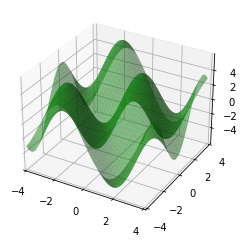

In [66]:
# Ground truth
limit = [-4, 4]
x0 = np.arange(limit[0], limit[1], .1)
x1 = np.arange(limit[0], limit[1], .1)
x0, x1 = np.meshgrid(x0, x1)
y_truth = 6*sin(x0)*cos(x1)

ax = plt.figure().gca(projection='3d')
ax.set_xlim(limit[0], limit[1])
ax.set_ylim(limit[0], limit[1])
ax.set_xticks(np.arange(limit[0], limit[1]+0.01, 2))
ax.set_yticks(np.arange(limit[0], limit[1]+0.01, 2))
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='green', alpha=0.5)
plt.show()

In [67]:
rng = check_random_state(0)

def selected_function(X):
    return 6*sin(X[:, 0])*cos(X[:, 1])

In [68]:
X_train, y_train, X_test, y_test = train_test_generation(selected_function, limit=limit, n_samples=500)

Помимо этого добавим собственную функцию в функциональное множество в качестве примера:

In [69]:
from gplearn.functions import make_function

def pow_3(x1):
    f = x1**3
    return f

pow_3 = make_function(function=pow_3,name='pow3',arity=1)

Обновляем функциональное множество:

In [70]:
function_set = ['add', 'sub', 'mul', 'div', 'sin', 'cos', pow_3]

In [ ]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=70, stopping_criteria=0.01,
                           p_crossover=0.35, p_subtree_mutation=0.3,
                           p_hoist_mutation=0.05, p_point_mutation=0.3,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0, function_set=function_set)
est_gp.fit(X_train, y_train)

Результирующее дерево:

In [ ]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1_child', format='png', cleanup=True)
graph

In [ ]:
est_tree.fit(X_train, y_train)
est_rf.fit(X_train, y_train)
y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

results = [(y_truth, None, "Ground Truth"),
           (y_gp, score_gp, "SymbolicRegressor"),                            
           (y_tree, score_tree, "DecisionTreeRegressor"),
           (y_rf, score_rf, "RandomForestRegressor")]


compare_graphs(results, limit =limit, label_position = (-.6, 1, 7), h_between_ticks=1)

Попробуем ограничить функциональное множество

In [74]:
function_set = ['add', 'sub', 'mul', 'tan']

Заново запускаем алгоритм 

In [ ]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=40, stopping_criteria=0.01,
                           p_crossover=0.35, p_subtree_mutation=0.3,
                           p_hoist_mutation=0.05, p_point_mutation=0.3,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0, function_set=function_set)
est_gp.fit(X_train, y_train)

In [ ]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1_child', format='png', cleanup=True)
graph

# Symbolic Transformer

In [77]:
from gplearn.genetic import SymbolicTransformer
from sklearn.utils import check_random_state
from sklearn.datasets import load_boston
import numpy as np

Подгружаем данные и перемешаем их

In [78]:
rng = check_random_state(0)
boston = load_boston()
perm = rng.permutation(boston.target.size)
boston.data = boston.data[perm]
boston.target = boston.target[perm]

Применим Ридж-Регрессию для этого примера: 

In [79]:
from sklearn.linear_model import Ridge
est = Ridge()
est.fit(boston.data[:300, :], boston.target[:300])
print("Ridge score:", est.score(boston.data[300:, :], boston.target[300:]))

Ridge score: 0.7593194530498838


Теперь применим алгоритм из gplearn добавив в функциональное множество побольше функций.

In [ ]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0)
gp.fit(boston.data[:300, :], boston.target[:300])

gp_features = gp.transform(boston.data)
new_boston = np.hstack((boston.data, gp_features))

est = Ridge()
est.fit(new_boston[:300, :], boston.target[:300])
print("GP score", est.score(new_boston[300:, :], boston.target[300:]))

# Symbolic Classifier
Посмотреть самостоятельно:
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html